The purpose of this part is to analyse and explore the data to find features that are likely indicators of spam or ham.

Since, the body is the most significant field in an email and has the content that spammers use to exploit thier targets, we generate a word cloud from the body of all spam emails.

### If on Google Colab

In [85]:
!pip install PyDrive

In [86]:
!pip install wordcloud

In [87]:
!pip install xlrd

In [0]:
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
!rm -rf structured.xlsx

In [0]:
download = drive.CreateFile({'id': '1oh_fic0-1N1xh4OlTvGMQ5BTKjOmUYKi'})
download.GetContentFile('structured.xlsx')

In [92]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /content/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /content/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### If not on Google Colab

### Word Cloud

There are certain words that spammers' use very commonly in their email's to catch the attention of their targets. We try to find such words from the email body by constructing a word cloud from our spam dataset. Bigger words in the word cloud are one's that occur more frequently in the dataset.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import wordcloud
import re


Importing the excel file we created in part-1 into a pandas dataframe. We use a converter to convert all empty cell values to np.NaN and non-empty cell values to string type.

In [2]:
# converter
def conv(content):
    '''
    convert datatype to string or np.NaN
    '''
    # check for NaN 
    if(content != content):
        return np.NaN
    # else convert to string
    return str(content)
    

In [3]:
converters = {'Spam':conv, 'Body':conv, 'Subject':conv, 'From':conv, 'To':conv, 'X-UIDL':conv, 'Message-Id':conv, 'Sender':conv}

In [4]:
mails = pd.read_excel('structured.xlsx', index_col=None, converters=converters )

In [5]:
mails.head()

,From,To,Message-Id,Subject,Body,Spam,X-UIDL,Sender
0,aj881c <aj881c@ix.netcom.com>\n,<bagpipes@acadia.net>\n,<19943672.886214@relay.comanche.denmark.eu> M...,2-1\n,email marketing works!!\n\nbull's eye gold is ...,Spam,NaN,NaN
1,iwbp@mailcity.com\n,members@your.net\n,<>\n,"Exclusive Internet Business, 1st Time Offered...",>>>this is the most exciting breakthrough ever...,Spam,NaN,NaN
2,am74rt <am74rt@worldnet.att.net>\n,<badams@eastky.com>\n,<19943672.886214@relay.comanche.denmark.eu> T...,2-17\n,email marketing works!!\n\nbull's eye gold is ...,Spam,NaN,NaN
3,"""D.Reynolds"" <subwiz1@friendlyserver.com>\n",NaN,<199802161222.EAA24869@net1.aoci.com>\n,ADV: FREE DOWNLOAD:Register your web site to ...,free download.register your web site to over 7...,Spam,NaN,NaN
4,carlover@goplay.com\n,carlovers@america.com\n,<>\n,AUTOMOBILE OPPORTUNITY\n,do you love cars?\n\nwant your own business?\n...,Spam,NaN,NaN


To filter out meaningless words and generate a cleaner word cloud, we use the nltk package to: 
1. remove all punctuation using regex & convert to lower case
2. Tokenize, stem (Porter stemmer) & remove stop words

In [6]:
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords

In [7]:
def transformBody(body):
    '''
    data preprocessing steps
    '''
    # removing ' character (eg. dollar's -> dollars)
    # remove other puctuation
    body = str(body).replace("'", "")
    body = re.sub(r"[^\w\s]|_", "", body)
    #body = re.sub("[\s+]", " ", body)

    # to lower case
    bodylower = body.lower()
    
    # tokenize, stem and remove stop words
    bodylist = word_tokenize(bodylower)
    stemmer = PorterStemmer()
    stemmedlist = [stemmer.stem(word) for word in bodylist]
    sw = stopwords.words('english')
    finalist = [word for word in bodylist if(word not in sw)]
    return finalist

Filtering out body column for spam rows 

In [8]:
spamBodies = mails[mails['Spam'] == 'Spam']['Body']

Preprocess spam body

In [9]:
spamBodies2 = spamBodies.map(transformBody)

Aggregating all spam rows to generate wordcloud

In [10]:
spam_words = ' '.join(np.concatenate(spamBodies2.values.tolist()).tolist())

Using wordcloud package to generate the wordcloud.

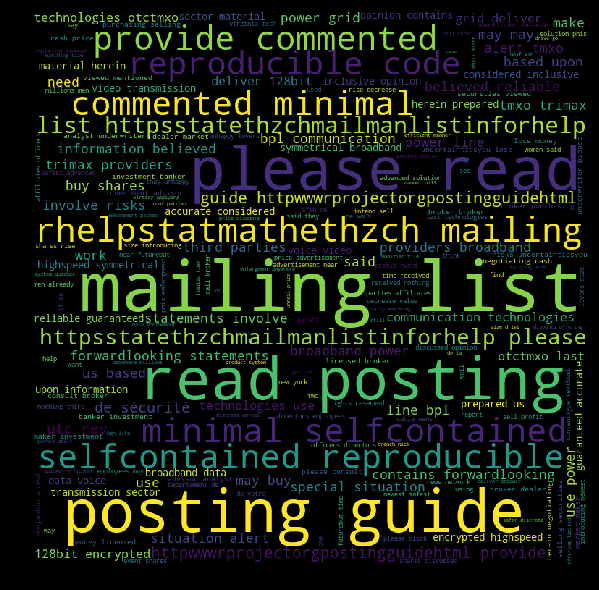

In [11]:
spam_wc = wordcloud.WordCloud(width=768, height=768).generate(spam_words)
plt.figure(figsize=(10,8), facecolor='k')
plt.imshow(spam_wc)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()


### Wordcloud inference:

Words like mailing, list, retail, price, per, item, posting are frequently found in spam emails. They indicate that the spammer wants to sell an item or send spams after user is subscribed to a mailing list or job posting.

In [12]:
#spamBodies['whereHTML'] = spamBodies['Body'].apply(lambda x: x[x.find('tm3')-30:] if(str(x).find('tm3') != -1) else np.NaN)

In [13]:
#spamBodies[spamBodies['whereHTML'].notna()]['whereHTML']

In [14]:
#print(spamBodies.ix[41]['Body'])

## Engineering features from Email Headers

Email headers show the route an email has taken before arriving at its recipient. It contains important information like sender, recipient, message-id, date and time, subject etc. 

There are two reasons why spammers try to malform email headers.<br/>
    1.They try to conceil their identity and real source of the email.<br/>
    2.They try to conceil the fact that the email was part of a mass mailing effort.

FEATURE1: Spammers will sometimes enter all recipients in the Bcc field, and the address in the 'From' field is used in the 'To' field. Creating a new column 'Feature1' where 1 indicates 'From' field is the same as 'To' field, 0 indicates otherwise.

In [15]:
df_final = mails

In [16]:
# Feature1 -> From same as To. If yes -> 1, else 0
df_final['Feature1'] = 0
df_final.loc[df_final['From'] == df_final['To'], 'Feature1'] = 1
df_final['Feature1'].describe()

count    5039.000000
mean        0.001985
std         0.044508
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: Feature1, dtype: float64

FEATURE2: Again, because spammers send out emails by filling the 'Bcc' field, they sometimes leave the 'To' field empty or with an invalid string. Creating a new column 'Feature2' where 1 indicates invalid or NaN 'To' field, 0 indicates otherwise.

The method defined below splits the passed string around the ',' character, to get individual email addresses, 
which are stripped off of the new line chars. Method can handle email address strings like 
`"Tomas Jacobs" <RickyAmes@aol.com>` also. Regex is then used to check format correctness

In [17]:
import re
def isValidEmailFormat(emails):
    '''
    regex to check valid email addresses where 0 is valid and 1 is invalid
    '''
    for email in str(emails).split(','):
        if(email.isspace() or len(email) == 0):
            continue
            
        email = re.sub(r'(\n+)', r' ', str(email)).strip()
        print(email)
        
        if(re.match(r"(.+)<(.+)>|<(.+)>", email)):
            email = email[email.find("<")+1:-1]
            print(0, email)
            
        if(len(email) > 7):
            if(re.match("^.+@([?)[a-zA-Z0-9-.]+.([a-zA-Z]{2,3}|[0-9]{1,3})(]?))$", email) != None):
                print('continue')
                continue
            else:
                print('1')
                return 1
        else:
            return 1
        
    return 0

In [18]:
# Feature2 -> is the To column na or invalid ? 1->invalid, 0->valid
df_final['Feature2'] = 0
df_final['Feature2'] = df_final['To'].map(isValidEmailFormat)
df_final.loc[df_final['To'].isna(),'Feature2'] = 1
df_final[df_final['Feature2'] == 1][['Feature2','To']]

<bagpipes@acadia.net>
0 bagpipes@acadia.net
continue
members@your.net
continue
<badams@eastky.com>
0 badams@eastky.com
continue
nan
carlovers@america.com
continue
bait@mikhail.qcc.sk.ca
continue
<badmin@forum-de-beyrouth.com.lb>
0 badmin@forum-de-beyrouth.com.lb
continue
UDog244@aol.com
continue
baileyl@cream.cambridge.scr.slb.com
continue
baileyl@delphi.com
continue
baileyl@erols.com
continue
user@aol.com
continue
bguenter@gemprint.com
continue
buratuss_ef@bigfoot.com
continue
guluimai67@msn.com
continue
<vworlds@vworlds.com>
0 vworlds@vworlds.com
continue
p40508@presence4u.com
continue
bruceg@qcc.sk.ca
continue
usr999@aol.com
continue
BeSeen@At.Our.Site.com
continue
bguenter@gemprint.com       Is your site listed with the top search engines?  ListMe will       list you with 50 search engines and indexes for $90.       Satisfaction guaranteed!  Search engines are the only way most people have to find internet sites. But if your site is not listed
1
bruce.guenter@gemprint.com       Is 

0 catchall@speedy.uwaterloo.ca
continue
<the00@plg.uwaterloo.ca>
0 the00@plg.uwaterloo.ca
continue
ktwarwic@SPEEDY.UWATERLOO.CA
continue
<1@speedy.uwaterloo.ca>
0 1@speedy.uwaterloo.ca
continue
<theorize@plg.uwaterloo.ca>
0 theorize@plg.uwaterloo.ca
continue
<chortled@plg.uwaterloo.ca>
0 chortled@plg.uwaterloo.ca
continue
"gvreugde" <gvreugde@plg.uwaterloo.ca>
0 gvreugde@plg.uwaterloo.ca
continue
<manager@speedy.uwaterloo.ca>
0 manager@speedy.uwaterloo.ca
continue
ktwarwic@speedy.uwaterloo.ca
continue
"Milton Cezar Ribeiro" <milton_ruser@yahoo.com.br>
0 milton_ruser@yahoo.com.br
continue
"R-help" <r-help@stat.math.ethz.ch>
0 r-help@stat.math.ethz.ch
continue
producttestpanel@speedy.uwaterloo.ca
continue
<sktwarwic@speedy.uwaterloo.ca>
0 sktwarwic@speedy.uwaterloo.ca
continue
<producttestpanel@speedy.uwaterloo.ca> Precedence: normal
0 producttestpanel@speedy.uwaterloo.ca> Precedence: norma
1
BREAKINGNEWS Subscribers<BREAKINGNEWS-Subscribers@foxnews.com>
0 BREAKINGNEWS-Subscribers@foxnew

0 gnitpick@speedy.uwaterloo.ca
continue
"ktwarwic" <ktwarwic@speedy.uwaterloo.ca>
0 ktwarwic@speedy.uwaterloo.ca
continue
"the00" <the00@plg.uwaterloo.ca>
0 the00@plg.uwaterloo.ca
continue
"the00" <the00@plg.uwaterloo.ca>
0 the00@plg.uwaterloo.ca
continue
"the00" <the00@plg.uwaterloo.ca>
0 the00@plg.uwaterloo.ca
continue
"the00" <the00@plg2.math.uwaterloo.ca>
0 the00@plg2.math.uwaterloo.ca
continue
samba-cvs@samba.org
continue
ktwarwic@SPEEDY.UWATERLOO.CA
continue
<warwickktwarwic@speedy.uwaterloo.ca>
0 warwickktwarwic@speedy.uwaterloo.ca
continue
<soundtrackdeficient@speedy.uwaterloo.ca>
0 soundtrackdeficient@speedy.uwaterloo.ca
continue
manager@speedy.uwaterloo.ca
continue
gnitpick@speedy.uwaterloo.ca
continue
Gabor Grothendieck <ggrothendieck@gmail.com>
0 ggrothendieck@gmail.com
continue
<catchall@speedy.uwaterloo.ca>
0 catchall@speedy.uwaterloo.ca
continue
R packages list <r-packages@stat.math.ethz.ch>
0 r-packages@stat.math.ethz.ch
continue
"Jarod" <ktwarwic@speedy.uwaterloo.ca>
0

<elaastic@speedy.uwaterloo.ca>
0 elaastic@speedy.uwaterloo.ca
continue
samba-cvs@samba.org
continue
<the00@plg.uwaterloo.ca>
0 the00@plg.uwaterloo.ca
continue
<catchall@speedy.uwaterloo.ca>
0 catchall@speedy.uwaterloo.ca
continue
<faisalabad@speedy.uwaterloo.ca>
0 faisalabad@speedy.uwaterloo.ca
continue
"ktwarwic" <ktwarwic@speedy.uwaterloo.ca>
0 ktwarwic@speedy.uwaterloo.ca
continue
"mhln" <mhln@mhln.com>
0 mhln@mhln.com
continue
the00@plg.uwaterloo.ca
continue
gnitpick@speedy.uwaterloo.ca
continue
<mack@speedy.uwaterloo.ca>
0 mack@speedy.uwaterloo.ca
continue
Theorize <theorize@plg.uwaterloo.ca>
0 theorize@plg.uwaterloo.ca
continue
Acm <the00@plg.uwaterloo.ca>
0 the00@plg.uwaterloo.ca
continue
theorize@plg.uwaterloo.ca
continue
samba-cvs@samba.org
continue
theorize@plg.uwaterloo.ca
continue
the00@speedy.uwaterloo.ca
continue
<ktwarwic@speedy.uwaterloo.ca>
0 ktwarwic@speedy.uwaterloo.ca
continue
<elaastic@speedy.uwaterloo.ca>
0 elaastic@speedy.uwaterloo.ca
continue
"the00" <the00@plg.

<the00@plg.uwaterloo.ca>
0 the00@plg.uwaterloo.ca
continue
perl6-internals@perl.org
continue
parrot-porters@perl.org
continue
ktwarwic@speedy.uwaterloo.ca
continue
"Jose Quesada " <quesada@gmail.com>
0 quesada@gmail.com
continue
<ktwarwic@speedy.uwaterloo.ca>
0 ktwarwic@speedy.uwaterloo.ca
continue
<ktwarwic@speedy.uwaterloo.ca>
0 ktwarwic@speedy.uwaterloo.ca
continue
samba-cvs@samba.org
continue
ktwarwic@speedy.uwaterloo.ca
continue
<the00@plg.uwaterloo.ca>
0 the00@plg.uwaterloo.ca
continue
"Theorize" <theorize@plg.uwaterloo.ca>
0 theorize@plg.uwaterloo.ca
continue
"theorize" <theorize@plg.uwaterloo.ca>
0 theorize@plg.uwaterloo.ca
continue
samba-technical@lists.samba.org
continue
<the00@plg.uwaterloo.ca>
0 the00@plg.uwaterloo.ca
continue
catchall@speedy.uwaterloo.ca
continue
"mhln" <mhln@mhln.com>
0 mhln@mhln.com
continue
<the00@plg2.math.uwaterloo.ca>
0 the00@plg2.math.uwaterloo.ca
continue
<gnitpick@speedy.uwaterloo.ca>
0 gnitpick@speedy.uwaterloo.ca
continue
<gnitpick@speedy.uwater

"'Jim Lemon'" <jim@bitwrit.com.au>
0 jim@bitwrit.com.au
continue
"'Pedro A Reche'" <reche@research.dfci.harvard.edu> References: <66C18F5B-FEAD-440A-AC9D-DFAD53B145EA@research.dfci.harvard.edu> 	<4624A333.2020109@bitwrit.com.au>
0 reche@research.dfci.harvard.edu> References: <66C18F5B-FEAD-440A-AC9D-DFAD53B145EA@research.dfci.harvard.edu> 	<4624A333.2020109@bitwrit.com.au
continue
the00@plg.uwaterloo.ca
continue
producttestpanel@speedy.uwaterloo.ca
continue
"theorize" <theorize@plg.uwaterloo.ca>
0 theorize@plg.uwaterloo.ca
continue
"Zada" <theorize@plg.uwaterloo.ca>
0 theorize@plg.uwaterloo.ca
continue
<the00@plg.uwaterloo.ca>
0 the00@plg.uwaterloo.ca
continue
gnitpick@speedy.uwaterloo.ca
continue
gnitpick@speedy.uwaterloo.ca
continue
<producttestpanel@speedy.uwaterloo.ca> Precedence: normal
0 producttestpanel@speedy.uwaterloo.ca> Precedence: norma
1
<catchall@speedy.uwaterloo.ca>
0 catchall@speedy.uwaterloo.ca
continue
Robert McFadden <robert-mcfadden@o2.pl>
0 robert-mcfadden@o2.pl
co

"catchall" <catchall@speedy.uwaterloo.ca>
0 catchall@speedy.uwaterloo.ca
continue
ktwarwic@speedy.uwaterloo.ca
continue
themadvlad@speedy.uwaterloo.ca
continue
ktwarwic@speedy.uwaterloo.ca
continue
r-help@stat.math.ethz.ch
continue
"gnitpick" <gnitpick@speedy.uwaterloo.ca>
0 gnitpick@speedy.uwaterloo.ca
continue
"catchall" <catchall@speedy.uwaterloo.ca>
0 catchall@speedy.uwaterloo.ca
continue
adtrevors@plg2.math.uwaterloo.ca
continue
<mhln@mhln.com>
0 mhln@mhln.com
continue
soundtrackdeficient@speedy.uwaterloo.ca
continue
"Weiwei Shi" <helprhelp@gmail.com>
0 helprhelp@gmail.com
continue
"smiles" <smiles@speedy.uwaterloo.ca>
0 smiles@speedy.uwaterloo.ca
continue
bugs-bitbucket@netlabs.develooper.com
continue
<producttestpanel@speedy.uwaterloo.ca> Precedence: normal
0 producttestpanel@speedy.uwaterloo.ca> Precedence: norma
1
<gnitpick@speedy.uwaterloo.ca>
0 gnitpick@speedy.uwaterloo.ca
continue
<ktwarwic@speedy.uwaterloo.ca>
0 ktwarwic@speedy.uwaterloo.ca
continue
"Subscriber" <productte

0 r-help@stat.math.ethz.ch
continue
<r-help-request@stat.math.ethz.ch>
0 r-help-request@stat.math.ethz.ch
continue
sugar@laptop.org
continue
"Subscriber" <producttestpanel@speedy.uwaterloo.ca>
0 producttestpanel@speedy.uwaterloo.ca
continue
samba-cvs@samba.org
continue
gnitpick@speedy.uwaterloo.ca
continue
"ktwarwic" <ktwarwic@speedy.uwaterloo.ca>
0 ktwarwic@speedy.uwaterloo.ca
continue
gjditchf@plg.uwaterloo.ca
continue
the00@plg.uwaterloo.ca
continue
gnitpick@speedy.uwaterloo.ca
continue
gnitpick@speedy.uwaterloo.ca
continue
<smiles@speedy.uwaterloo.ca>
0 smiles@speedy.uwaterloo.ca
continue
AbouEl-Makarim Aboueissa <aaboueissa@usm.maine.edu> References: <4624C9F2.A437.00A6.0@usm.maine.edu>
0 aaboueissa@usm.maine.edu> References: <4624C9F2.A437.00A6.0@usm.maine.edu
continue
Ip-health <ip-health@lists.essential.org>
0 ip-health@lists.essential.org
continue
ktwarwic@speedy.uwaterloo.ca
continue
catchall@speedy.uwaterloo.ca
continue
r-help@stat.math.ethz.ch
continue
r-help@stat.math.ethz

0 ip-health@lists.essential.org
continue
Ip-health <ip-health@lists.essential.org>
0 ip-health@lists.essential.org
continue
<manager@speedy.uwaterloo.ca>
0 manager@speedy.uwaterloo.ca
continue
samba-cvs@samba.org
continue
James Peach <jpeach@samba.org> References: <20070417221248.E5BA3162C2E@lists.samba.org> 	<2D62765F-890A-4287-8330-37764DCA8B0D@samba.org>
0 jpeach@samba.org> References: <20070417221248.E5BA3162C2E@lists.samba.org> 	<2D62765F-890A-4287-8330-37764DCA8B0D@samba.org
continue
"Subscriber" <producttestpanel@speedy.uwaterloo.ca>
0 producttestpanel@speedy.uwaterloo.ca
continue
Ip-health <ip-health@lists.essential.org>
0 ip-health@lists.essential.org
continue
<catchall@speedy.uwaterloo.ca>
0 catchall@speedy.uwaterloo.ca
continue
<elaastic@speedy.uwaterloo.ca>
0 elaastic@speedy.uwaterloo.ca
continue
"Theorize" <theorize@plg.uwaterloo.ca>
0 theorize@plg.uwaterloo.ca
continue
"Marco Pesenti Gritti" <mpg@redhat.com>
0 mpg@redhat.com
continue
parrot-porters@perl.org
continue
"Perl

0 the00@plg2.math.uwaterloo.ca
continue
tridge@samba.org References: <E1HdqDI-0008Fd-Ar@intern.SerNet.DE> 	<E1HdvRc-0002zY-BV@intern.SerNet.DE> 	<17957.20263.755596.506465@samba.org> 	<17957.29642.812135.596922@samba.org>
0 E1HdqDI-0008Fd-Ar@intern.SerNet.DE> 	<E1HdvRc-0002zY-BV@intern.SerNet.DE> 	<17957.20263.755596.506465@samba.org> 	<17957.29642.812135.596922@samba.org
continue
the00@plg2.math.uwaterloo.ca
continue
the00@plg.uwaterloo.ca
continue
the00@plg2.math.uwaterloo.ca
continue
the00@plg.uwaterloo.ca
continue
"mail" <mail@speedy.uwaterloo.ca>
0 mail@speedy.uwaterloo.ca
continue
"grant" <dmason@plg2.math.uwaterloo.ca>
0 dmason@plg2.math.uwaterloo.ca
continue
ktwarwic@speedy.uwaterloo.ca
continue
<the00@plg.uwaterloo.ca>
0 the00@plg.uwaterloo.ca
continue
<the00@plg2.math.uwaterloo.ca>
0 the00@plg2.math.uwaterloo.ca
continue
theorize@plg.uwaterloo.ca
continue
<henna@plg.uwaterloo.ca>
0 henna@plg.uwaterloo.ca
continue
debian-legal@lists.debian.org
continue
the00@plg.uwaterloo.ca
c

"gnitpick" <gnitpick@speedy.uwaterloo.ca>
0 gnitpick@speedy.uwaterloo.ca
continue
"catchall" <catchall@speedy.uwaterloo.ca>
0 catchall@speedy.uwaterloo.ca
continue
<theorize@plg.uwaterloo.ca>
0 theorize@plg.uwaterloo.ca
continue
"Petr PIKAL" <petr.pikal@precheza.cz>
0 petr.pikal@precheza.cz
continue
sktwarwic@speedy.uwaterloo.ca
continue
samba-technical@lists.samba.org References: <E1He8AO-0008KA-CR@intern.SerNet.DE>
0 E1He8AO-0008KA-CR@intern.SerNet.DE
continue
Gnitpick <gnitpick@speedy.uwaterloo.ca>
0 gnitpick@speedy.uwaterloo.ca
continue
samba-cvs@samba.org
continue
r-help@stat.math.ethz.ch
continue
"theorize" <theorize@plg.uwaterloo.ca>
0 theorize@plg.uwaterloo.ca
continue
warwic@speedy.uwaterloo.ca
continue
warwick@speedy.uwaterloo.ca
continue
the00@plg.uwaterloo.ca
continue
warwickktwarwic@speedy.uwaterloo.ca
continue
jjosh@speedy.uwaterloo.ca
continue
"the00" <the00@plg.uwaterloo.ca>
0 the00@plg.uwaterloo.ca
continue
samba-cvs@samba.org
continue
<antelopehn@speedy.uwaterloo.ca>


0 the00@plg.uwaterloo.ca
continue
<warwick@plg.uwaterloo.ca>
0 warwick@plg.uwaterloo.ca
continue
<the00@plg.uwaterloo.ca>
0 the00@plg.uwaterloo.ca
continue
producttestpanel@speedy.uwaterloo.ca
continue
mail@speedy.uwaterloo.ca
continue
"theorize" <theorize@plg.uwaterloo.ca>
0 theorize@plg.uwaterloo.ca
continue
r-help <r-help@stat.math.ethz.ch>
0 r-help@stat.math.ethz.ch
continue
<theorize@plg.uwaterloo.ca>
0 theorize@plg.uwaterloo.ca
continue
<producttestpanel@speedy.uwaterloo.ca> Precedence: normal
0 producttestpanel@speedy.uwaterloo.ca> Precedence: norma
1
"theorize" <theorize@plg.uwaterloo.ca>
0 theorize@plg.uwaterloo.ca
continue
jiri sasek - Sun Microsystems - Prague Czech Republic <Jiri.Sasek@sun.com>
0 Jiri.Sasek@sun.com
continue
producttestpanel@speedy.uwaterloo.ca
continue
<theorize@plg.uwaterloo.ca>
0 theorize@plg.uwaterloo.ca
continue
"Speakup is a screen review system for Linux." <speakup@braille.uwo.ca>
0 speakup@braille.uwo.ca
continue
Smiles <smiles@speedy.uwaterloo.ca>
0

0 r-help@stat.math.ethz.ch
continue
<ktwarwic@speedy.uwaterloo.ca>
0 ktwarwic@speedy.uwaterloo.ca
continue
ktwarwic@SPEEDY.UWATERLOO.CA
continue
"Gauthier
1
ip-health@lists.essential.org content-transfer-encoding: 7bit content-type: text/plain;  charset=ISO-8859-1;  format=flowed
1
<theorize@plg.uwaterloo.ca>
0 theorize@plg.uwaterloo.ca
continue
<the00@plg.uwaterloo.ca>
0 the00@plg.uwaterloo.ca
continue
manager@speedy.uwaterloo.ca
continue
the00@plg.uwaterloo.ca
continue
the00@plg2.math.uwaterloo.ca
continue
theorize@plg.uwaterloo.ca
continue
"the00" <the00@plg.uwaterloo.ca>
0 the00@plg.uwaterloo.ca
continue
"the00" <the00@plg2.math.uwaterloo.ca>
0 the00@plg2.math.uwaterloo.ca
continue
samba-cvs@samba.org
continue
producttestpanel@speedy.uwaterloo.ca
continue
samba-cvs@samba.org
continue
"theorize" <theorize@plg.uwaterloo.ca>
0 theorize@plg.uwaterloo.ca
continue
samba-cvs@samba.org
continue
<antelopehn@speedy.uwaterloo.ca>
0 antelopehn@speedy.uwaterloo.ca
continue
samba-cvs@samba.org
c

"theorize" <theorize@plg.uwaterloo.ca>
0 theorize@plg.uwaterloo.ca
continue
gnitpick@speedy.uwaterloo.ca
continue
mail@speedy.uwaterloo.ca
continue
manager@speedy.uwaterloo.ca
continue
"manager" <manager@speedy.uwaterloo.ca>
0 manager@speedy.uwaterloo.ca
continue
"catchall" <catchall@speedy.uwaterloo.ca>
0 catchall@speedy.uwaterloo.ca
continue
"gnitpick" <gnitpick@speedy.uwaterloo.ca>
0 gnitpick@speedy.uwaterloo.ca
continue
"manager" <manager@speedy.uwaterloo.ca>
0 manager@speedy.uwaterloo.ca
continue
samba-cvs@samba.org
continue
gnitpick@speedy.uwaterloo.ca
continue
samba-cvs@samba.org
continue
gnitpick@speedy.uwaterloo.ca
continue
producttestpanel@speedy.uwaterloo.ca
continue
manager@speedy.uwaterloo.ca
continue
"gnitpick" <gnitpick@speedy.uwaterloo.ca>
0 gnitpick@speedy.uwaterloo.ca
continue
producttestpanel@speedy.uwaterloo.ca
continue
samba-cvs@samba.org
continue
samba-cvs@samba.org
continue
"the00" <the00@plg.uwaterloo.ca>
0 the00@plg.uwaterloo.ca
continue
samba-cvs@samba.org
con

0 ajmalton@plg.uwaterloo.ca
continue
<henna@plg.uwaterloo.ca>
0 henna@plg.uwaterloo.ca
continue
<asharji@plg.uwaterloo.ca>
0 asharji@plg.uwaterloo.ca
continue
<chortled@plg.uwaterloo.ca>
0 chortled@plg.uwaterloo.ca
continue
<chortlede@plg.uwaterloo.ca>
0 chortlede@plg.uwaterloo.ca
continue
<theorize@plg.uwaterloo.ca>
0 theorize@plg.uwaterloo.ca
continue
<dmason@plg.uwaterloo.ca>
0 dmason@plg.uwaterloo.ca
continue
<dziegler@plg.uwaterloo.ca>
0 dziegler@plg.uwaterloo.ca
continue
<elterra@plg.uwaterloo.ca>
0 elterra@plg.uwaterloo.ca
continue
<fjburkowski@plg.uwaterloo.ca>
0 fjburkowski@plg.uwaterloo.ca
continue
<ktwarwic@plg.uwaterloo.ca>
0 ktwarwic@plg.uwaterloo.ca
continue
nishi@plg.uwaterloo.ca
continue
<the00@plg2.math.uwaterloo.ca>
0 the00@plg2.math.uwaterloo.ca
continue
dmason@plg.uwaterloo.ca
continue
beginners@perl.org
continue
gnitpick@speedy.uwaterloo.ca
continue
catchall@speedy.uwaterloo.ca
continue
<elaastic@speedy.uwaterloo.ca>
0 elaastic@speedy.uwaterloo.ca
continue
manager@

0 S.Pickett@exeter.ac.uk
continue
"Theorize" <theorize@plg.uwaterloo.ca>
0 theorize@plg.uwaterloo.ca
continue
oopla@murphy.debian.org
continue
debian-laptop@lists.debian.org
continue
"Kumar Pritam" <kumarpritam84@gmail.com>
0 kumarpritam84@gmail.com
continue
india@laptop.org
continue
sugar@laptop.org
continue
cruiseca@speedy.uwaterloo.ca
continue
samba-cvs@samba.org
continue
"theorize" <theorize@plg.uwaterloo.ca>
0 theorize@plg.uwaterloo.ca
continue
ktwarwic@speedy.uwaterloo.ca
continue
"gnitpick" <gnitpick@speedy.uwaterloo.ca>
0 gnitpick@speedy.uwaterloo.ca
continue
samba-cvs@samba.org
continue
THE00@plg.uwaterloo.ca
continue
Guenther Deschner <gd@samba.org> References: <20070419131309.C7D05163941@lists.samba.org> 	<46276F77.9020005@samba.org> <4627826E.7090309@samba.org>
0 gd@samba.org> References: <20070419131309.C7D05163941@lists.samba.org> 	<46276F77.9020005@samba.org> <4627826E.7090309@samba.org
continue
"Subscriber" <producttestpanel@speedy.uwaterloo.ca>
0 producttestpanel@speed

continue
"the00" <the00@plg.uwaterloo.ca>
0 the00@plg.uwaterloo.ca
continue
"the00" <the00@plg2.math.uwaterloo.ca>
0 the00@plg2.math.uwaterloo.ca
continue
debian-desktop@lists.debian.org
continue
debian-edu@lists.debian.org
continue
<the00@plg.uwaterloo.ca>
0 the00@plg.uwaterloo.ca
continue
<deficient@speedy.uwaterloo.ca>
0 deficient@speedy.uwaterloo.ca
continue
<ktwarwic@speedy.uwaterloo.ca>
0 ktwarwic@speedy.uwaterloo.ca
continue
<the00@plg.uwaterloo.ca>
0 the00@plg.uwaterloo.ca
continue
ktwarwic@SPEEDY.UWATERLOO.CA
continue
samba-cvs@samba.org
continue
<mail@speedy.uwaterloo.ca>
0 mail@speedy.uwaterloo.ca
continue
ktwarwic@speedy.uwaterloo.ca
continue
r-help@stat.math.ethz.ch
continue
<the00@plg.uwaterloo.ca>
0 the00@plg.uwaterloo.ca
continue
<adtrevors@plg.uwaterloo.ca>
0 adtrevors@plg.uwaterloo.ca
continue
<aeehassa@plg.uwaterloo.ca>
0 aeehassa@plg.uwaterloo.ca
continue
"Subscriber" <producttestpanel@speedy.uwaterloo.ca>
0 producttestpanel@speedy.uwaterloo.ca
continue
the00@plg2.m

smiles@speedy.uwaterloo.ca
continue
<elaastic@speedy.uwaterloo.ca>
0 elaastic@speedy.uwaterloo.ca
continue
<ktwarwic@speedy.uwaterloo.ca>
0 ktwarwic@speedy.uwaterloo.ca
continue
gnitpick@speedy.uwaterloo.ca
continue
smiles@speedy.uwaterloo.ca
continue
"mail" <mail@speedy.uwaterloo.ca>
0 mail@speedy.uwaterloo.ca
continue
r-help@stat.math.ethz.ch
continue
ktwarwic@speedy.uwaterloo.ca
continue
gnitpick@speedy.uwaterloo.ca
continue
"Theorize" <theorize@plg.uwaterloo.ca>
0 theorize@plg.uwaterloo.ca
continue
SMILE@speedy.uwaterloo.ca
continue
R-Help <r-help@stat.math.ethz.ch>
0 r-help@stat.math.ethz.ch
continue
SMILES@speedy.uwaterloo.ca
continue
"manager" <manager@speedy.uwaterloo.ca>
0 manager@speedy.uwaterloo.ca
continue
theorize@plg.uwaterloo.ca
continue
myl@cis.upenn.edu
continue
<the00@plg2.math.uwaterloo.ca>
0 the00@plg2.math.uwaterloo.ca
continue
myl@cis.upenn.edu
continue
r-help@stat.math.ethz.ch
continue
mail@speedy.uwaterloo.ca
continue
perl6-internals@perl.org
continue
gnitpick@s

,Feature2,To
3,1,NaN
18,1,bguenter@gemprint.com \n\n Is your site l...
19,1,bruce.guenter@gemprint.com \n\n Is your s...
20,1,bguenter@linus.vsource.com \n\n Is your s...
108,1,"Kuhn, Max\n"
159,1,NaN
203,1,NaN
224,1,<producttestpanel@speedy.uwaterloo.ca>\nPrece...
234,1,<producttestpanel@speedy.uwaterloo.ca>\nPrece...
242,1,NaN


FEATURE3: Since the 'Message-Id' contains information about where the email is coming from, in spam mails, it is typically missing or malformed. Message-Ids are of the form xxx@domain.com. The method below checks the correctness of the Message-Id format. Creating a new column 'Feature3' where 1 indicates Message-ID malformed or missing, 0 indicates otherwise. 

In [19]:
import re
def isValidMessageID(mid):
    '''
    checks for valid domain in message id where 0 is valid and 1 is invalid
    '''
    for email in str(mid).split('\n'):
        if(email.isspace() or len(email) == 0 or email.find('@') < 0):
            continue
            
        email = email.strip()
        print(email)
        
        if(re.match(r"(.+)?<<(.+)@(.+)>>(.+)?", email)):
            email = email[email.find("<<")+1:email.rfind(">>")]
            print(0, email)
        
        if(re.match(r"(.+)?<(.+)@(.+)>(.+)?", email)):
            email = email[email.find("<")+1:email.rfind(">")]
            print(0, email)
            
        if(len(email) > 7):
            if(re.match("^.+@([?)[a-zA-Z0-9-.]+.([a-zA-Z]{2,3}|[0-9]{1,3})(]?))$", email) != None):
                return 0
            else:
                continue
        else:
            continue
        
    return 1

Displaying Message-Id values that are malformed.

In [20]:
# Feature3 -> is the Message-Id column na or invalid ? 1->invalid, 0->valid
df_final['Feature3'] = 0
df_final['Feature3'] = df_final['Message-Id'].map(isValidMessageID)
df_final.loc[df_final['Message-Id'].isna(),'Feature3'] = 1
df_final.loc[df_final['Feature3'] == 1][['Feature3','Message-Id']]

<19943672.886214@relay.comanche.denmark.eu> Monday, February 2nd, 1998
0 19943672.886214@relay.comanche.denmark.eu
<19943672.886214@relay.comanche.denmark.eu> Tuesday, February 17th, 1998
0 19943672.886214@relay.comanche.denmark.eu
<199802161222.EAA24869@net1.aoci.com>
0 199802161222.EAA24869@net1.aoci.com
<19943672.886214@relay.comanche.denmark.eu> Friday, March 6th, 1998
0 19943672.886214@relay.comanche.denmark.eu
<367a6bc2.35086056@aol.com>
0 367a6bc2.35086056@aol.com
<a4193ab9.35086277@aol.com>
0 a4193ab9.35086277@aol.com
<<34B589AA.83376E4D@hotmail.com>>
0 <34B589AA.83376E4D@hotmail.com
<199803140024.GAA02943@1arbiscad.com>
0 199803140024.GAA02943@1arbiscad.com
<199803251503EAA37015@post.ideasign.com>
0 199803251503EAA37015@post.ideasign.com
<0EQG00DSE4M7MP@PM04SM.PMM.MCI.NET>
0 0EQG00DSE4M7MP@PM04SM.PMM.MCI.NET
<199803270303.WAA02236@ns.owlseye.com>
0 199803270303.WAA02236@ns.owlseye.com
<199803270121.TAA11252@linus.vsource.com>
0 199803270121.TAA11252@linus.vsource.com
<19980327

<01c7803b$fd325af0$6c822ecf@millinersfrillier>
0 01c7803b$fd325af0$6c822ecf@millinersfrillier
<000301c78039$c3b811e0$c83814aa@cbs.ad.cbs.net>
0 000301c78039$c3b811e0$c83814aa@cbs.ad.cbs.net
<462391F6.7010300@ktl.fi>
0 462391F6.7010300@ktl.fi
<6288910E4C67941.66B7007C8D@t-dialin.net>
0 6288910E4C67941.66B7007C8D@t-dialin.net
<911b01c7803b$ee2dbe18$5acb8f8b@seductive.com>
0 911b01c7803b$ee2dbe18$5acb8f8b@seductive.com
<db2401c7803b$1d90a151$2d560179@rome.com>
0 db2401c7803b$1d90a151$2d560179@rome.com
<000001c7803c$9f28e900$0100007f@localhost>
0 000001c7803c$9f28e900$0100007f@localhost
<235401c77adc$4b20aea7$2b2cbcf3@fishhoo.com>
0 235401c77adc$4b20aea7$2b2cbcf3@fishhoo.com
<01c76a35$320ad490$6c822ecf@interruptedoutcasts>
0 01c76a35$320ad490$6c822ecf@interruptedoutcasts
<46239691-kfdyd-1c@toilskirting.com>
0 46239691-kfdyd-1c@toilskirting.com
<01c7803c$d1a31ef0$6c822ecf@dwcodanm>
0 01c7803c$d1a31ef0$6c822ecf@dwcodanm
<01c7803c$d5c35590$6c822ecf@dwmaderthanerm>
0 01c7803c$d5c35590$6c822ecf

<20070416164645.1kfpql6ewdiosk44@www.ausnetit.com.au>
0 20070416164645.1kfpql6ewdiosk44@www.ausnetit.com.au
<000f01c7804f$73088b60$00177524@mario>
0 000f01c7804f$73088b60$00177524@mario
<01c78068$e3fecff0$6c822ecf@outlaidsavage>
0 01c78068$e3fecff0$6c822ecf@outlaidsavage
<001501c78079$d59a3600$068d1efc@xpsp215d524446>
0 001501c78079$d59a3600$068d1efc@xpsp215d524446
<001b01c78079$d65b6320$0692a95c@xpsp215d524446>
0 001b01c78079$d65b6320$0692a95c@xpsp215d524446
<001c01c78047$5954ee00$0140e35c@particullhl8bl>
0 001c01c78047$5954ee00$0140e35c@particullhl8bl
<000e01c78047$59a86530$0667f704@particullhl8bl>
0 000e01c78047$59a86530$0667f704@particullhl8bl
<1073913632.251839499.qmail@rangesender.com>
0 1073913632.251839499.qmail@rangesender.com
<000c01c78068$e136af40$7537a043@istechws2>
0 000c01c78068$e136af40$7537a043@istechws2
<001801c78079$cc6381e0$0094081c@pausab>
0 001801c78079$cc6381e0$0094081c@pausab
<001c01c78079$c4bedf70$0140ff7c@Sondre>
0 001c01c78079$c4bedf70$0140ff7c@Sondre
<001601c

0 20070417025252.1C575162BD6@lists.samba.org
<BYAEWHAORGFGPWAKMIRSCJCW@livedoor.com>
0 BYAEWHAORGFGPWAKMIRSCJCW@livedoor.com
<DQAEQAMVIDCLXOHRAXNS@hotmail.com>
0 DQAEQAMVIDCLXOHRAXNS@hotmail.com
<000701c780e1$6802cf40$439f2c36@jayz.co.nz>
0 000701c780e1$6802cf40$439f2c36@jayz.co.nz
<000e01b1a5bd$aeab2dd0$0140f04c@1230c73a226800>
0 000e01b1a5bd$aeab2dd0$0140f04c@1230c73a226800
<0fea81879f042e46364f3ad0b80fd@google.com>
0 0fea81879f042e46364f3ad0b80fd@google.com
<031e01c78101$3daa45d0$8946e2e0@arcad>
0 031e01c78101$3daa45d0$8946e2e0@arcad
<06bb01c78109$3dca34c0$4155e3c0@zcrisisq>
0 06bb01c78109$3dca34c0$4155e3c0@zcrisisq
<6.1.0.6.2.20070416174536.04832ea8@mail.statistics.com>
0 6.1.0.6.2.20070416174536.04832ea8@mail.statistics.com
<000001c7809d$771da200$0100007f@hsstudent>
0 000001c7809d$771da200$0100007f@hsstudent
<200704170309.l3H3970I022437@speedy.uwaterloo.ca>
0 200704170309.l3H3970I022437@speedy.uwaterloo.ca
<04bb01c78107$3fbc25f0$3401a9b0@lcassandraj>
0 04bb01c78107$3fbc25f0$3401a9

0 20070417083248.9006916480E@ws1-4.us4.outblaze.com
<001101c780f9$b672d720$0160b294@GNET3>
0 001101c780f9$b672d720$0160b294@GNET3
<4291692454.164kogou@dyn-htl-14300.dyn.columbia.edu>
0 4291692454.164kogou@dyn-htl-14300.dyn.columbia.edu
<000601c780cc$1cc33f70$a47e9f99@aixo>
0 000601c780cc$1cc33f70$a47e9f99@aixo
<37288365469122.DF424E141C@MOTPR7>
0 37288365469122.DF424E141C@MOTPR7
<000f01c7809a$222d46e0$06208f6c@jessica>
0 000f01c7809a$222d46e0$06208f6c@jessica
<000f01c7810f$bbfea9b0$067cdabc@F877BBDE677945A>
0 000f01c7810f$bbfea9b0$067cdabc@F877BBDE677945A
<bf3701c780dc$c42136e0$7ed5a12d@eddie-bauerfxato>
0 bf3701c780dc$c42136e0$7ed5a12d@eddie-bauerfxato
<200704092050.l39KoP0I019565@speedy.uwaterloo.ca>
0 200704092050.l39KoP0I019565@speedy.uwaterloo.ca
<01c780cc$dd74ede0$6c822ecf@dwlyfrabucm>
0 01c780cc$dd74ede0$6c822ecf@dwlyfrabucm
<c36001c780cc$dacf246b$a9e7758a@core.lv>
0 c36001c780cc$dacf246b$a9e7758a@core.lv
<811c01c780cc$d7ec8aee$e2a59084@bboy.com>
0 811c01c780cc$d7ec8aee$e2a59084

0 20070417031538.12707.qmail@host81-156-2-230.range81-156.btcentralplus.com
<001501c7810b$b141eea0$07ebe9dc@ferran>
0 001501c7810b$b141eea0$07ebe9dc@ferran
<000f01c78146$763706c0$002f842c@home76h44388sx>
0 000f01c78146$763706c0$002f842c@home76h44388sx
<000b01c78096$784b50c0$0200000a@bzq-88-155-214-150.red.bezeqint.net>
0 000b01c78096$784b50c0$0200000a@bzq-88-155-214-150.red.bezeqint.net
<000e01c78104$0c4e9f80$06eada7c@homebase5h65gn>
0 000e01c78104$0c4e9f80$06eada7c@homebase5h65gn
<000001c780fb$63a12400$82e6bf42@RAC>
0 000001c780fb$63a12400$82e6bf42@RAC
<001801c780fb$b2e22460$68356923@lypfw>
0 001801c780fb$b2e22460$68356923@lypfw
<20070417102014.93E931B4C8016@payoutmatched.com>
0 20070417102014.93E931B4C8016@payoutmatched.com
<01c780fb$bef93c20$6c822ecf@a_pode>
0 01c780fb$bef93c20$6c822ecf@a_pode
<91c201c78179$6cdd52c3$0375d33b@bartbaggett.com>
0 91c201c78179$6cdd52c3$0375d33b@bartbaggett.com
<8.8.2.8.8.61122300584965.414a9575@129.97.186.80>
0 8.8.2.8.8.61122300584965.414a9575@129.97.1

0 20070417073539.130912.qmail@rrcs-70-63-23-195.central.biz.rr.com
<001401c78159$a1b38e00$06717f6c@leev31q5429fgn>
0 001401c78159$a1b38e00$06717f6c@leev31q5429fgn
<20070417173607.ks2jm.288151383@ebs.bbc.co.uk>
0 20070417173607.ks2jm.288151383@ebs.bbc.co.uk
<20070417163625.1D9B2163D71@lists.samba.org>
0 20070417163625.1D9B2163D71@lists.samba.org
<001101c7811f$5534c740$01406b14@MICHEL>
0 001101c7811f$5534c740$01406b14@MICHEL
<3B8E363C6A7F47B0A7EE6C2B94759AFD@pelmorex.ca>
0 3B8E363C6A7F47B0A7EE6C2B94759AFD@pelmorex.ca
<001901c780f5$bff1b4a0$068505bc@computador>
0 001901c780f5$bff1b4a0$068505bc@computador
<4624ed0a-qq0el4unr@wistfulsea.com>
0 4624ed0a-qq0el4unr@wistfulsea.com
<001501c77b09$5186f670$082e00f4@home3s2syyjlzr>
0 001501c77b09$5186f670$082e00f4@home3s2syyjlzr
<10038426.post@talk.nabble.com>
0 10038426.post@talk.nabble.com
<001101c78117$ae296d90$00648854@pandora2d78749>
0 001101c78117$ae296d90$00648854@pandora2d78749
<Pine.LNX.4.64.0704170930510.24845@tajo.ucsd.edu>
0 Pine.LNX.4.

<200704172135.l3HLZA0I000985@speedy.uwaterloo.ca>
0 200704172135.l3HLZA0I000985@speedy.uwaterloo.ca
<001301c77a30$005c0d00$06543f44@PC290514210214>
0 001301c77a30$005c0d00$06543f44@PC290514210214
<987CBE79D07C4636A4A4C5909005B130@pelmorex.ca>
0 987CBE79D07C4636A4A4C5909005B130@pelmorex.ca
<A3BD0F02C590290.C361118E39@esw-stolberg.com>
0 A3BD0F02C590290.C361118E39@esw-stolberg.com
<7AC4798144A1CD1.4BB3DB8DFE@cbp21.com>
0 7AC4798144A1CD1.4BB3DB8DFE@cbp21.com
<200704172136.l3HLaE0J001005@speedy.uwaterloo.ca>
0 200704172136.l3HLaE0J001005@speedy.uwaterloo.ca
<000001c7817c$09947300$f8962cc4@kcr-b835a88c9b0>
0 000001c7817c$09947300$f8962cc4@kcr-b835a88c9b0
<3PT84D62EK02TDBZ@DN730O3U5203CY553P49T1>
0 3PT84D62EK02TDBZ@DN730O3U5203CY553P49T1
<E1HdvRc-0002zY-BV@intern.SerNet.DE>
0 E1HdvRc-0002zY-BV@intern.SerNet.DE
<86y7kq657s.fsf@pullcord.laptop.org>
0 86y7kq657s.fsf@pullcord.laptop.org
<440593753.80147123408334@thhebat.net>
0 440593753.80147123408334@thhebat.net
<200704172147.l3HLlF0I001097@spe

0 000b01c78153$01ed8340$0101a8c0@adsl-074-247-007-211.sip.aby.bellsouth.net
<TcKTqswr3Mlj44zeyKOepg@allthesefree.com>
0 TcKTqswr3Mlj44zeyKOepg@allthesefree.com
<971536df0704171751u557e9a25j7cf170f01dfe94d4@mail.gmail.com>
0 971536df0704171751u557e9a25j7cf170f01dfe94d4@mail.gmail.com
<01c78153$af4b6110$6c822ecf@james>
0 01c78153$af4b6110$6c822ecf@james
<001101b4728a$9c416230$00d47f6c@AEAD321059704F2>
0 001101b4728a$9c416230$00d47f6c@AEAD321059704F2
<01c78155$6a81e750$6c822ecf@silencersadvantages>
0 01c78155$6a81e750$6c822ecf@silencersadvantages
<01c78156$0a36c2c0$6c822ecf@mundanelyplacards>
0 01c78156$0a36c2c0$6c822ecf@mundanelyplacards
<200704092256.l39Mu2QF018522@ema8adm1.turner.com>
0 200704092256.l39Mu2QF018522@ema8adm1.turner.com
<473319.1176858558031.JavaMail.Administrator@ap6>
0 473319.1176858558031.JavaMail.Administrator@ap6
<001101c78156$d10802cf$b54b514d@cinemexicano.com>
0 001101c78156$d10802cf$b54b514d@cinemexicano.com
<21E6A3FD-33EB-49B0-A5C0-8E913F6A11C3@hanover.edu>
0 21E

0 01c7ec5f$bdd994f0$6c822ecf@dwbellevilleshoem
<01c7ec5f$be1b58e0$6c822ecf@dwbeuzekomm>
0 01c7ec5f$be1b58e0$6c822ecf@dwbeuzekomm
<200704082053.l38Kre0I005252@speedy.uwaterloo.ca>
0 200704082053.l38Kre0I005252@speedy.uwaterloo.ca
<001901c77b17$0764cfa0$01906ab4@natiye3i5qkr9p>
0 001901c77b17$0764cfa0$01906ab4@natiye3i5qkr9p
<200704180628.l3I6S90I006020@speedy.uwaterloo.ca>
0 200704180628.l3I6S90I006020@speedy.uwaterloo.ca
<001401c781c5$c7fff7d0$061a838c@j>
0 001401c781c5$c7fff7d0$061a838c@j
<001701c781c5$dc904010$0664ff54@j>
0 001701c781c5$dc904010$0664ff54@j
<2.8.8.9.6.25693320191631.121a0955@129.97.78.23>
0 2.8.8.9.6.25693320191631.121a0955@129.97.78.23
<4625baba.6e525a32.027e.41b5@mx.google.com>
0 4625baba.6e525a32.027e.41b5@mx.google.com
<198c87380704171547r7e36f132q803aee7778d60f65@mail.gmail.com>
0 198c87380704171547r7e36f132q803aee7778d60f65@mail.gmail.com
<4625bb2d.17e8bc61.2a10.41af@mx.google.com>
0 4625bb2d.17e8bc61.2a10.41af@mx.google.com
<000001c78183$3ac47180$0100007f@nom-b

0 200704181054.l3IAso0J009266@speedy.uwaterloo.ca
<20070418035552.24042.qmail@Server>
0 20070418035552.24042.qmail@Server
<20070418035602.24054.qmail@Server>
0 20070418035602.24054.qmail@Server
<20070418035604.24058.qmail@Server>
0 20070418035604.24058.qmail@Server
<200704181056.l3IAuo0J009297@speedy.uwaterloo.ca>
0 200704181056.l3IAuo0J009297@speedy.uwaterloo.ca
<001a01c781b0$9f1550f0$05c871fc@bfb84086c535e4>
0 001a01c781b0$9f1550f0$05c871fc@bfb84086c535e4
<5862875.1176893648304.JavaMail.root@localhost>
0 5862875.1176893648304.JavaMail.root@localhost
<200704181100.l3IB0T0J009336@speedy.uwaterloo.ca>
0 200704181100.l3IB0T0J009336@speedy.uwaterloo.ca
<01c77b01$9f89f230$6c822ecf@rebukingyelps>
0 01c77b01$9f89f230$6c822ecf@rebukingyelps
<200704181101.l3IB1LV3021962@mail101.netcontentinc.net>
0 200704181101.l3IB1LV3021962@mail101.netcontentinc.net
<1176894091.24880.2.camel@localhost.localdomain>
0 1176894091.24880.2.camel@localhost.localdomain
<1176894103.24880.4.camel@localhost.localdomai

0 20070418101407.D73A46A192EDE@taxescontrol.net
<7.0.0.16.0.20070418100632.01f20ab0@carolina.rr.com>
0 7.0.0.16.0.20070418100632.01f20ab0@carolina.rr.com
<001201c781d5$07eae440$0742832c@miguel>
0 001201c781d5$07eae440$0742832c@miguel
<20070418151816.834B65C4923@ganieda.vernstok.nl>
0 20070418151816.834B65C4923@ganieda.vernstok.nl
<20070418141834.62E9C163B39@lists.samba.org>
0 20070418141834.62E9C163B39@lists.samba.org
<001b01c77b5b$2646c100$07610d8c@tuymaada31t9jw>
0 001b01c77b5b$2646c100$07610d8c@tuymaada31t9jw
<46262884.6070905@bebac.at>
0 46262884.6070905@bebac.at
<462627cd-kceyd-1c@unhappysaint.com>
0 462627cd-kceyd-1c@unhappysaint.com
<239583.230541078.1176877437@goldenmojo.com>
0 239583.230541078.1176877437@goldenmojo.com
<3-1616349-5Duzq4UwwbgwDrKbGNgDbbqj94prwbuGzz9Ur@mkt-out75.mktexpertise.net>
0 3-1616349-5Duzq4UwwbgwDrKbGNgDbbqj94prwbuGzz9Ur@mkt-out75.mktexpertise.net
<0BD0DF9C5E46FB6.AA5E33832F@blackdiamondranch.com>
0 0BD0DF9C5E46FB6.AA5E33832F@blackdiamondranch.com
<992CD

<546201c781bf$01c781bf$33453d46@speedy.uwaterloo.ca>
0 546201c781bf$01c781bf$33453d46@speedy.uwaterloo.ca
<20070418134003.186535d2.celejar@gmail.com>
0 20070418134003.186535d2.celejar@gmail.com
<000001c781e0$8d804680$0100007f@localhost>
0 000001c781e0$8d804680$0100007f@localhost
<001001c781b7$4d79e1a0$0271fd24@erbyofcoolness>
0 001001c781b7$4d79e1a0$0271fd24@erbyofcoolness
<fad888a10704181039n5d9c2047wec057ccbc3cd8f0d@mail.gmail.com>
0 fad888a10704181039n5d9c2047wec057ccbc3cd8f0d@mail.gmail.com
<f40401c781fa$c99ada80$7d3681f0@mailmij.nl>
0 f40401c781fa$c99ada80$7d3681f0@mailmij.nl
<87FF62B7CF67642.80EE1407D3@ne.jp>
0 87FF62B7CF67642.80EE1407D3@ne.jp
<01c77b0a$171833e0$6c822ecf@purveyhastiness>
0 01c77b0a$171833e0$6c822ecf@purveyhastiness
<001801c781af$64e6dda0$05cbaf04@NOMBRE36E71PX4>
0 001801c781af$64e6dda0$05cbaf04@NOMBRE36E71PX4
<001801c781f2$985478d0$002a7f9c@hjqcw85rys8xbx>
0 001801c781f2$985478d0$002a7f9c@hjqcw85rys8xbx
<MAILSENDERNG3GKeD021272c0e6@129.97.78.23>
0 MAILSENDERNG3GK

0 003c01c78206$7e32c6a0$e85df2cf@webserver.accuwx.com
<20070418221157.GA1429@stack.nl>
0 20070418221157.GA1429@stack.nl
<255640f90704181455r201ca74t824ecf17ae5093f9@mail.gmail.com>
0 255640f90704181455r201ca74t824ecf17ae5093f9@mail.gmail.com
<462697ee.4d535714.1b1a.ffffe093@mx.google.com>
0 462697ee.4d535714.1b1a.ffffe093@mx.google.com
<1176934326.21646.22.camel@localhost.localdomain>
0 1176934326.21646.22.camel@localhost.localdomain
<c540fe260704181513s14f76e42nfb5d2c89021c067d@mail.gmail.com>
0 c540fe260704181513s14f76e42nfb5d2c89021c067d@mail.gmail.com
<001a01c7820f$45631470$06060fcc@jessicaxwrgf0j>
0 001a01c7820f$45631470$06060fcc@jessicaxwrgf0j
<1-104393-6ul0vB7rrGbrufzGFNbuGGvJPB2frGlF00P7f@mx201.dollardbox.com>
0 1-104393-6ul0vB7rrGbrufzGFNbuGGvJPB2frGlF00P7f@mx201.dollardbox.com
<1-104393-88czhRb8L9RMbbQ.7z6LsbcOtt78L@mx201.dollardbox.com>
0 1-104393-88czhRb8L9RMbbQ.7z6LsbcOtt78L@mx201.dollardbox.com
<20070418221642.9BC01162AEE@lists.samba.org>
0 20070418221642.9BC01162AEE@list

0 BA8296B72BCE467.32EC8D5E4C@rr.com
<001a01c84032$577e0c00$0669eed4@pentium>
0 001a01c84032$577e0c00$0669eed4@pentium
<200704190127.l3J1RC0I018589@speedy.uwaterloo.ca>
0 200704190127.l3J1RC0I018589@speedy.uwaterloo.ca
<20070419012618.718D2162AF1@lists.samba.org>
0 20070419012618.718D2162AF1@lists.samba.org
<20070419012638.97322162AF1@lists.samba.org>
0 20070419012638.97322162AF1@lists.samba.org
<001b01c78264$f961b8a0$00c7e244@a>
0 001b01c78264$f961b8a0$00c7e244@a
<20070419012746.28DB8162AF1@lists.samba.org>
0 20070419012746.28DB8162AF1@lists.samba.org
<001301c7826e$975f09f0$05f785ec@computer4>
0 001301c7826e$975f09f0$05f785ec@computer4
<001301c78265$bc395450$062ef33c@billgates>
0 001301c78265$bc395450$062ef33c@billgates
<8-vnnqv0zvii$f36@98jp.8cw>
0 8-vnnqv0zvii$f36@98jp.8cw
<5pu2lq$1ggskg@cnnimail25.turner.com>
0 5pu2lq$1ggskg@cnnimail25.turner.com
<77A8752893CF2D3.8093BF43C4@charter.com>
0 77A8752893CF2D3.8093BF43C4@charter.com
<20070419013214.307CD79D88@mta2.qsnews.net>
0 2007041901

0 20070419092604.605C4162BC3@lists.samba.org
<10074629.post@talk.nabble.com>
0 10074629.post@talk.nabble.com
<01c78266$06c446b0$6c822ecf@befuddlingmisapprehending>
0 01c78266$06c446b0$6c822ecf@befuddlingmisapprehending
<001601c78265$fc5cdac0$e0777d91@bxkb>
0 001601c78265$fc5cdac0$e0777d91@bxkb
<200704190937.l3J9bH0I022869@speedy.uwaterloo.ca>
0 200704190937.l3J9bH0I022869@speedy.uwaterloo.ca
<bfda01c77b1c$24b47d05$ba548b26@ausi.com>
0 bfda01c77b1c$24b47d05$ba548b26@ausi.com
<812558070.21301861439792@thhebat.net>
0 812558070.21301861439792@thhebat.net
<5900B027628EE19.6728E5E905@claytonwilliams.com>
0 5900B027628EE19.6728E5E905@claytonwilliams.com
<020494360.92972853091477@thhebat.net>
0 020494360.92972853091477@thhebat.net
<BC8A3862.029FA9BE@fit.com>
0 BC8A3862.029FA9BE@fit.com
<web-87183457@tl3.webmaillogin.com>
0 web-87183457@tl3.webmaillogin.com
<000001c78267$4ab58180$0100007f@localhost>
0 000001c78267$4ab58180$0100007f@localhost
<1BY4RH$Y4F1TX7838X38091QOH8SBU0JHLR019X@commtouch.co

0 20070419093609.51B7A14D17C34@commonblog.net
<46277087.2050902@samba.org>
0 46277087.2050902@samba.org
<47fce0650704190559qa9d85adqfffc4467d554dad7@mail.gmail.com>
0 47fce0650704190559qa9d85adqfffc4467d554dad7@mail.gmail.com
<801e01c78227$fa8823f0$d421efaf@aagwjfpu>
0 801e01c78227$fa8823f0$d421efaf@aagwjfpu
<744834621.23441903245645@thhebat.net>
0 744834621.23441903245645@thhebat.net
<353381250.20276325063851@thhebat.net>
0 353381250.20276325063851@thhebat.net
<01c78288$24303250$6c822ecf@southerlieslikable>
0 01c78288$24303250$6c822ecf@southerlieslikable
<10077840.post@talk.nabble.com>
0 10077840.post@talk.nabble.com
<001701c7826f$4ab93160$00cd843c@terminal10>
0 001701c7826f$4ab93160$00cd843c@terminal10
<001501c7826f$4af4dad0$017e1cf4@terminal10>
0 001501c7826f$4af4dad0$017e1cf4@terminal10
<1115a2b00704092032y323ed00i2bc67c9192545572@mail.gmail.com>
0 1115a2b00704092032y323ed00i2bc67c9192545572@mail.gmail.com
<20070419134144.9CE3844073@ws5-1.us4.outblaze.com>
0 20070419134144.9CE38440

0 001101c7827b$9d45bcd0$06f256c4@S1013
<01c782a4$86e37710$6c822ecf@rupturehandkerchief's>
0 01c782a4$86e37710$6c822ecf@rupturehandkerchief's
<20070419170128.GC7346@jeremy2.wintest.samba.local>
0 20070419170128.GC7346@jeremy2.wintest.samba.local
<1177002352.2736@host135.londonfl.info>
0 1177002352.2736@host135.londonfl.info
<200704191706.l3JH6d0J027280@speedy.uwaterloo.ca>
0 200704191706.l3JH6d0J027280@speedy.uwaterloo.ca
<000001c782a5$11036b80$0100007f@Janie>
0 000001c782a5$11036b80$0100007f@Janie
<4627A2BB.4060108@samba.org>
0 4627A2BB.4060108@samba.org
<3halpern.largemouthB@province.org>
0 3halpern.largemouthB@province.org
<000f01c77b04$88ba39e0$006461c4@thinkcentre>
0 000f01c77b04$88ba39e0$006461c4@thinkcentre
<001001c782b7$eab73610$00195db4@marciniv9pdjlg>
0 001001c782b7$eab73610$00195db4@marciniv9pdjlg
<20070419131757.29795401F7365@matchedtarget.net>
0 20070419131757.29795401F7365@matchedtarget.net
<001c01c782b8$17f84b50$0460fdc4@85183158bc71465>
0 001c01c782b8$17f84b50$0460fdc4@8

0 461B157A.9000602@solarsail.hcs.harvard.edu
<4627DBD4.80402@samba.org>
0 4627DBD4.80402@samba.org
<20070419210050.53B6C5951C2@borg.st.net.au>
0 20070419210050.53B6C5951C2@borg.st.net.au
<495131962.85713261474198@thhebat.net>
0 495131962.85713261474198@thhebat.net
<200704192119.l3JLJ20I029907@speedy.uwaterloo.ca>
0 200704192119.l3JLJ20I029907@speedy.uwaterloo.ca
<200704192121.l3JLL30J029929@speedy.uwaterloo.ca>
0 200704192121.l3JLL30J029929@speedy.uwaterloo.ca
<000001c782d0$b54ed780$fee29ba5@NYCDOE-C2C1265F>
0 000001c782d0$b54ed780$fee29ba5@NYCDOE-C2C1265F
<000001c782d0$b54ed780$fee29ba5@NYCDOE-C2C1265F>
0 000001c782d0$b54ed780$fee29ba5@NYCDOE-C2C1265F
<493860081.59100564550438@thhebat.net>
0 493860081.59100564550438@thhebat.net
<1177017577.4352.60.camel@localhost>
0 1177017577.4352.60.camel@localhost
<20070419212048.GE9889@gab.suse.de>
0 20070419212048.GE9889@gab.suse.de
<01c77b2b$27e8d910$6c822ecf@massivelyratios>
0 01c77b2b$27e8d910$6c822ecf@massivelyratios
<web-170623162@cgpsrv2.ci

<01c782fc$997db3b0$6c822ecf@figurerelegated>
0 01c782fc$997db3b0$6c822ecf@figurerelegated


,Feature3,Message-Id
1,1,<>\n
4,1,<>\n
5,1,Mach10 1.1 fxpromo.com\n
10,1,<199803250408.UAA03361>\n
13,1,NaN
16,1,<31867701_67397293>\n
24,1,<tryitbeforeyoubuyit>\n
29,1,199803272113.OOB5051@\n
31,1,NaN
34,1,<36424144_99983662>\n


FEATURE4: The 'X-UIDL' header is intended to stop the recepient's mail server from downloading multiple copies of the mail once the mail is received. Normally, X-UIDL is stripped once the mail is received. Spammers' intentionally add the X-UIDL, so that mail servers download multiple copies of the mail, increasing chances of it being read. Creating a new column 'Feature4', where 1 indicates X-UIDL not empty, 0 indicates otherwise.

Displaying rows where X-UIDL is not empty.

In [21]:
# Feature4, is the X-UIDL header not empty or na ? 1->not empty, 0->empty 
df_final['Feature4'] = 0
df_final.loc[df_final['X-UIDL'].notna(), 'Feature4'] = 1
df_final.loc[df_final['X-UIDL'].isna(), 'Feature4'] = 0
df_final.loc[df_final['Feature4']==1]['X-UIDL']

9      c89dd4e061ba173523703cf25c3133a2\n
11     763cf6e5123c1287a83f12d7e99c60c9\n
16                  10293287_192832.222\n
22     f2c3e4bf7654f32bfd17a6c54dc32f1d\n
24     11111111111111111111111111111111\n
26     2610431056a78aeb1b128fda426c9a5e\n
27                      123456789012376\n
28     33587715159195856343749765328732\n
29                        870483442.265\n
34                  20720340_201230.501\n
37     2610431056a78aeb1b128fda426c9a5e\n
Name: X-UIDL, dtype: object

Count analysis for feature 1

In [22]:
s = df_final[df_final['Spam'] == 'Ham']['Feature1']
s0 = s[s == 0]
s1 = s[s == 1]
print('Count of Ham emails that have a Different From and To', s0.count())
ham_feature1 = s1.count()
print('Count of Ham emails that have a Same From and To', ham_feature1)

s = df_final[df_final['Spam'] == 'Spam']['Feature1']
s0 = s[s == 0]
s1 = s[s == 1]
print('Count of Spam emails that have a Different From and To', s0.count())
spam_feature1 = s1.count()
print('Count of Spam emails that have a Same From and To', spam_feature1)

Count of Ham emails that have a Different From and To 1394
Count of Ham emails that have a Same From and To 2
Count of Spam emails that have a Different From and To 3635
Count of Spam emails that have a Same From and To 8


Count analysis for feature 2

In [23]:
s = df_final[df_final['Spam'] == 'Ham']['Feature2']
s0 = s[s == 0]
s1 = s[s == 1]
print('Count of Ham emails that have a valid To field', s0.count())
ham_feature2 = s1.count()
print('Count of Ham emails that have an inValid To field', ham_feature2)

s = df_final[df_final['Spam'] == 'Spam']['Feature2']
s0 = s[s == 0]
s1 = s[s == 1]
print('Count of spam emails that have a valid To field', s0.count())
spam_feature2 = s1.count()
print('Count of spam emails that have an inValid To field', spam_feature2)

Count of Ham emails that have a valid To field 1339
Count of Ham emails that have an inValid To field 57
Count of spam emails that have a valid To field 3519
Count of spam emails that have an inValid To field 124


Count analysis for feature 3

In [24]:
s = df_final[df_final['Spam'] == 'Ham']['Feature3']
s0 = s[s == 0]
s1 = s[s == 1]
print('Count of Ham emails that have a Valid Message-Id field', s0.count())
ham_feature3 = s1.count()
print('Count of Ham emails that have an InValid Message-Id field', ham_feature3)

s = df_final[df_final['Spam'] == 'Spam']['Feature3']
s0 = s[s == 0]
s1 = s[s == 1]
print('Count of Spam emails that have a Valid Message-Id field', s0.count())
spam_feature3 = s1.count()
print('Count of Spam emails that have an InValid Message-Id field', spam_feature3)

Count of Ham emails that have a Valid Message-Id field 1335
Count of Ham emails that have an InValid Message-Id field 61
Count of Spam emails that have a Valid Message-Id field 3461
Count of Spam emails that have an InValid Message-Id field 182


Count analysis for feature 4

In [25]:
s = df_final[df_final['Spam'] == 'Ham']['Feature4']
s0 = s[s == 0]
s1 = s[s == 1]
print('Count of Ham emails that have an empty X-UIDL field', s0.count())
ham_feature4 = s1.count()
print('Count of Ham emails that do not have an empty X-UIDL field', ham_feature4)

s = df_final[df_final['Spam'] == 'Spam']['Feature4']
s0 = s[s == 0]
s1 = s[s == 1]
print('Count of Spam emails that have an empty X-UIDL field', s0.count())
spam_feature4 = s1.count()
print('Count of Spam emails that do not have an empty X-UIDL field', spam_feature4)

Count of Ham emails that have an empty X-UIDL field 1396
Count of Ham emails that do not have an empty X-UIDL field 0
Count of Spam emails that have an empty X-UIDL field 3632
Count of Spam emails that do not have an empty X-UIDL field 11


x_data indicates number of bars in the chart displayed below later <br>
y_data is a numpy array of counts of all features calculated above <br>
y_sum is sum of spam and ham for y

In [26]:
x_data = (1,2,3,4)
y_data = np.array([[spam_feature1,spam_feature2,spam_feature3,spam_feature4],[ham_feature1,ham_feature2,ham_feature3,ham_feature4]])
y_sum = y_data[0]+y_data[1]


## Plot data

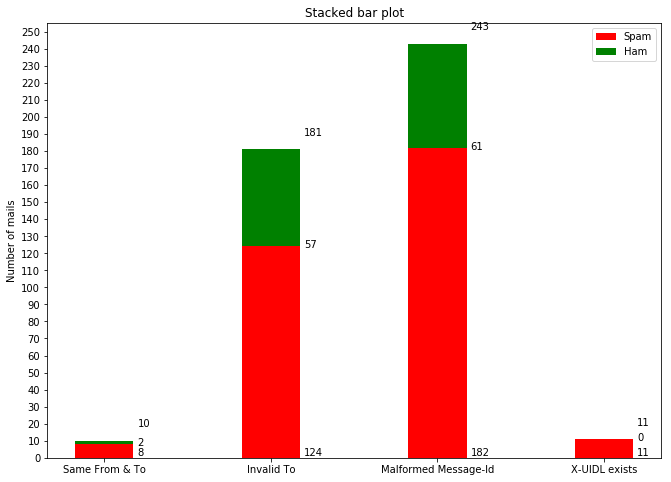

In [32]:
p1 = plt.bar(x_data,y_data[0],color='r',align='center',label=['f1','f2','f3','f4'], width=0.35)
p2 = plt.bar(x_data,y_data[1],color='g',bottom=y_data[0],align='center',label=['f1','f2','f3','f4'], width=0.35)
plt.ylabel('Number of mails')
plt.title('Stacked bar plot')
plt.xticks(x_data, ('Same From & To','Invalid To','Malformed Message-Id','X-UIDL exists'))
plt.yticks(np.arange(0,np.max(y_sum)+10,10))
plt.legend((p1[0],p2[0]),('Spam','Ham'),loc = 'upper right')

plt.text(1.20,1,spam_feature1)
plt.text(1.20,spam_feature1-1,ham_feature1)
plt.text(1.20,spam_feature1+ham_feature1+8,y_sum[0])

plt.text(2.20,1,spam_feature2)
plt.text(2.20,spam_feature2-1,ham_feature2)
plt.text(2.20,spam_feature2+ham_feature2+8,y_sum[1])

plt.text(3.20,1,spam_feature3)
plt.text(3.20,spam_feature3-1,ham_feature3)
plt.text(3.20,spam_feature3+ham_feature3+8,y_sum[2])

plt.text(4.20,1,spam_feature4)
plt.text(4.20,spam_feature4-1,ham_feature4)
plt.text(4.20,spam_feature4+ham_feature4+8,y_sum[3])

fig = plt.gcf()
fig.set_size_inches(11,8)
plt.show()

### Plot Inference

The above chart depicts our 4 email header features on the x-axis. Notice that the red bars (spam) are longer than the green (ham). This indicates that spam emails are more likely to exhibit these 4 features than ham emails.   

Also, 'Same From & To' & 'X-UIDL exists' do indicate spam, but they are weak indicators of spam mail. (Because it is possible that you may want to send an email to yourself) 